In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


file = "Revenue.xlsx"   

# Load each sheet
revenue       = pd.read_excel(file, sheet_name="revenue")
plans         = pd.read_excel(file, sheet_name="plan")
countries     = pd.read_excel(file, sheet_name="countries")
subscriptions = pd.read_excel(file, sheet_name="subscription")
customers       = pd.read_excel(file, sheet_name="customers")

In [19]:
df = pd.read_excel(file)
df.head()

,order_id,transaction_id,payment_date,amount,plan_id,payment_method,coupon_code
0,ORD000083071,56E2321457954E9AB02489B196C16449,"Sunday, March 23, 2025",69.45,2,google_pay,SPRING20
1,ORD000030497,E68ACDA4ED594B03856431919C29CDCD,2025-01-02,81.27,3,apple_pay,NaN
2,ORD000082941,5E4592F614254DEFA383B47A4A99C2F8,2025-08-11,140.42,2,paypal,NaN
3,ORD000002640,7C57DDAC85DF4910A9D0D1B0BCCCB15E,"Sunday, March 2, 2025",32.62,1,bank_transfer,NaN
4,ORD000002641,00399D7FD2EF4DFC8B3218AAACCFCB77,"Monday, May 5, 2025",82.55,3,bank_transfer,NaN


In [28]:
# Rename columns for consistency
plans = plans.rename(columns={"Id": "plan_id"})
countries = countries.rename(columns={"id": "country_id"})
customers = customers.rename(columns={"id": "customer_id"})
subscriptions = subscriptions.rename(columns={"id": "subscription_id"})



 Data Cleaning

In [29]:
revenue["payment_date"] = pd.to_datetime(revenue["payment_date"], errors="coerce")
revenue["amount"] = pd.to_numeric(revenue["amount"], errors="coerce")
customers = customers.loc[:, ~customers.columns.str.contains("Unnamed")]


In [37]:
# Merge all sheets
df = revenue.merge(subscriptions, on="order_id", how="left")
df = df.merge(plans, left_on="plan_id_x", right_on="plan_id", how="left")
df = df.merge(customers, on="customer_id", how="left")
df = df.merge(countries, on="country_id", how="left")

# Drop the extra plan_id column after merging with plans
df = df.drop(columns=["plan_id_y"])


df = df[[
    "customer_id","order_id","transaction_id","payment_date","amount",
    "plan_name","payment_method","coupon_code","country_name"
]]

print("Final dataset shape:", df.shape)
df.head()

Final dataset shape: (159569, 9)


,customer_id,order_id,transaction_id,payment_date,amount,plan_name,payment_method,coupon_code,country_name
0,1007,ORD000083071,56E2321457954E9AB02489B196C16449,2025-03-23,69.45,12-Month,google_pay,SPRING20,Samoa
1,1008,ORD000030497,E68ACDA4ED594B03856431919C29CDCD,NaT,81.27,6-Month,apple_pay,NaN,Angola
2,1009,ORD000082941,5E4592F614254DEFA383B47A4A99C2F8,NaT,140.42,12-Month,paypal,NaN,Angola
3,1010,ORD000002640,7C57DDAC85DF4910A9D0D1B0BCCCB15E,2025-03-02,32.62,3-Month,bank_transfer,NaN,Republic of the Congo
4,1010,ORD000002641,00399D7FD2EF4DFC8B3218AAACCFCB77,2025-05-05,82.55,6-Month,bank_transfer,NaN,Republic of the Congo


# Task 1
Analyze customer cohorts based on their first purchase using the provided data.

**Reasoning**:
Calculate the earliest and latest payment dates in the DataFrame to define the cohort time window.



In [38]:
cohort_start_date = df['payment_date'].min()
cohort_end_date = df['payment_date'].max()

print(f"Cohort analysis start date: {cohort_start_date}")
print(f"Cohort analysis end date: {cohort_end_date}")

Cohort analysis start date: 2025-02-01 00:00:00
Cohort analysis end date: 2025-05-31 00:00:00


In [39]:
df_sorted = df.sort_values(by=['customer_id', 'payment_date'])
first_purchase_per_customer = df_sorted.groupby('customer_id').head(1)
display(first_purchase_per_customer.head())

,customer_id,order_id,transaction_id,payment_date,amount,plan_name,payment_method,coupon_code,country_name
0,1007,ORD000083071,56E2321457954E9AB02489B196C16449,2025-03-23,69.45,12-Month,google_pay,SPRING20,Samoa
1,1008,ORD000030497,E68ACDA4ED594B03856431919C29CDCD,NaT,81.27,6-Month,apple_pay,NaN,Angola
2,1009,ORD000082941,5E4592F614254DEFA383B47A4A99C2F8,NaT,140.42,12-Month,paypal,NaN,Angola
3,1010,ORD000002640,7C57DDAC85DF4910A9D0D1B0BCCCB15E,2025-03-02,32.62,3-Month,bank_transfer,NaN,Republic of the Congo
5,1011,ORD000068900,834EE360CB1A476BA96477B9F79C3A8A,NaT,34.29,3-Month,credit_card,NaN,Austria


In [40]:
first_purchase_per_customer["cohort"] = first_purchase_per_customer["coupon_code"].apply(lambda x: 'Cohort B (Offer First Joiners)' if pd.notnull(x) else 'Cohort A (Non-Offer First Joiners)')
display(first_purchase_per_customer.head())

/tmp/ipython-input-3716800222.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_purchase_per_customer["cohort"] = first_purchase_per_customer["coupon_code"].apply(lambda x: 'Cohort B (Offer First Joiners)' if pd.notnull(x) else 'Cohort A (Non-Offer First Joiners)')


,customer_id,order_id,transaction_id,payment_date,amount,plan_name,payment_method,coupon_code,country_name,cohort
0,1007,ORD000083071,56E2321457954E9AB02489B196C16449,2025-03-23,69.45,12-Month,google_pay,SPRING20,Samoa,Cohort B (Offer First Joiners)
1,1008,ORD000030497,E68ACDA4ED594B03856431919C29CDCD,NaT,81.27,6-Month,apple_pay,NaN,Angola,Cohort A (Non-Offer First Joiners)
2,1009,ORD000082941,5E4592F614254DEFA383B47A4A99C2F8,NaT,140.42,12-Month,paypal,NaN,Angola,Cohort A (Non-Offer First Joiners)
3,1010,ORD000002640,7C57DDAC85DF4910A9D0D1B0BCCCB15E,2025-03-02,32.62,3-Month,bank_transfer,NaN,Republic of the Congo,Cohort A (Non-Offer First Joiners)
5,1011,ORD000068900,834EE360CB1A476BA96477B9F79C3A8A,NaT,34.29,3-Month,credit_card,NaN,Austria,Cohort A (Non-Offer First Joiners)


In [41]:
df = df.merge(first_purchase_per_customer[['customer_id', 'cohort']], on='customer_id', how='left')
display(df.head())

,customer_id,order_id,transaction_id,payment_date,amount,plan_name,payment_method,coupon_code,country_name,cohort
0,1007,ORD000083071,56E2321457954E9AB02489B196C16449,2025-03-23,69.45,12-Month,google_pay,SPRING20,Samoa,Cohort B (Offer First Joiners)
1,1008,ORD000030497,E68ACDA4ED594B03856431919C29CDCD,NaT,81.27,6-Month,apple_pay,NaN,Angola,Cohort A (Non-Offer First Joiners)
2,1009,ORD000082941,5E4592F614254DEFA383B47A4A99C2F8,NaT,140.42,12-Month,paypal,NaN,Angola,Cohort A (Non-Offer First Joiners)
3,1010,ORD000002640,7C57DDAC85DF4910A9D0D1B0BCCCB15E,2025-03-02,32.62,3-Month,bank_transfer,NaN,Republic of the Congo,Cohort A (Non-Offer First Joiners)
4,1010,ORD000002641,00399D7FD2EF4DFC8B3218AAACCFCB77,2025-05-05,82.55,6-Month,bank_transfer,NaN,Republic of the Congo,Cohort A (Non-Offer First Joiners)


## Analyze cohorts




In [42]:
cohort_counts = df.groupby('cohort')['customer_id'].nunique()
display(cohort_counts)

,customer_id
cohort,
Cohort A (Non-Offer First Joiners),26100
Cohort B (Offer First Joiners),24594


In [45]:
# Total number of unique customers in the cohort
total_unique_customers = first_purchase_per_customer['customer_id'].nunique()
print(f"Total number of unique customers in the cohort: {total_unique_customers}")

# Total revenue from those first purchases
total_first_purchase_revenue = first_purchase_per_customer['amount'].sum()
print(f"Total revenue from those first purchases: {total_first_purchase_revenue:.2f}")

Total number of unique customers in the cohort: 50694
Total revenue from those first purchases: 1788548.94


In [46]:
# Number of those first-time buyers who later made at least one additional purchase

# Get all customer IDs from the main dataframe
all_customer_ids = df['customer_id'].unique()

# Get customer IDs from the first purchase dataframe
first_time_buyer_ids = first_purchase_per_customer['customer_id'].unique()

# Find customer IDs that are in both lists AND have more than one transaction in the main df
repeat_buyers = df[df['customer_id'].isin(first_time_buyer_ids)].groupby('customer_id').filter(lambda x: len(x) > 1)['customer_id'].unique()

num_repeat_buyers = len(repeat_buyers)
print(f"Number of first-time buyers who later made at least one additional purchase: {num_repeat_buyers}")

Number of first-time buyers who later made at least one additional purchase: 20819


In [47]:
# Filter the main dataframe to include only repeat buyers
repeat_buyer_transactions = df[df['customer_id'].isin(repeat_buyers)].copy()

# Identify the first purchase date for each repeat buyer
first_purchase_dates = first_purchase_per_customer.set_index('customer_id')['payment_date'].to_dict()

# Filter out the first purchase for each repeat buyer
repeat_buyer_transactions['first_purchase_date'] = repeat_buyer_transactions['customer_id'].map(first_purchase_dates)
repeat_purchases = repeat_buyer_transactions[repeat_buyer_transactions['payment_date'] != repeat_buyer_transactions['first_purchase_date']]

# Calculate the total revenue from repeat purchases
total_repeat_purchase_revenue = repeat_purchases['amount'].sum()

print(f"Total revenue from repeat purchases: {total_repeat_purchase_revenue:.2f}")

Total revenue from repeat purchases: 3517558.70


Visualizations:

In [60]:
retention_pivot = cohort_group.pivot_table(index='cohort', columns='cohort_period', values='retention_rate')
retention_pivot = retention_pivot.fillna(0)
display(retention_pivot)

cohort_period,0,1,2,3,4
cohort,,,,,
Cohort A (Non-Offer First Joiners),1.0,0.048743,0.033450,0.011448,0.000715
Cohort B (Offer First Joiners),1.0,0.045263,0.030928,0.013255,0.000589


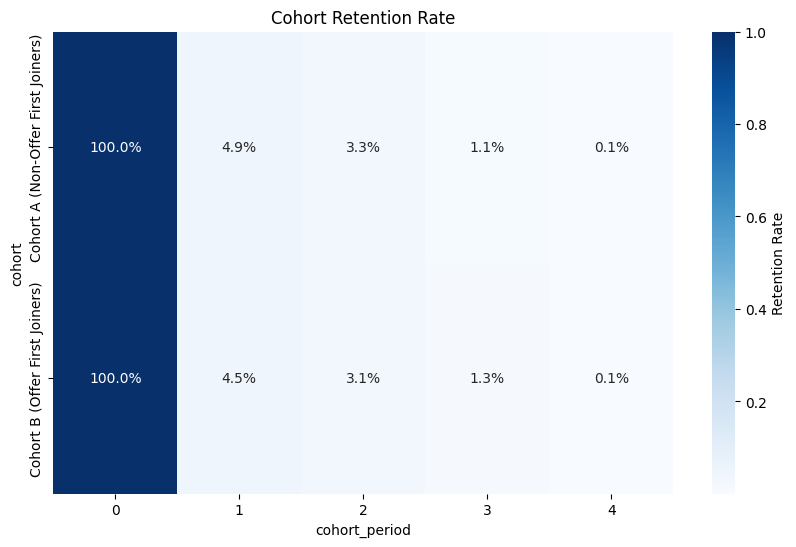

In [59]:
plt.figure(figsize=(10, 6))
sns.heatmap(retention_pivot, annot=True, fmt=".1%", cmap="Blues", cbar_kws={'label': 'Retention Rate'})
plt.title('Cohort Retention Rate')
plt.show()